In [ ]:
#!pip3 freeze > "../requirements.txt"
#!pip3 install -r "../requirements.txt"  # giving some error
from google.cloud import bigquery
import pandas as pd
import numpy as np
import pandas_gbq
import copy
import copy
import pickle
import datetime as dt
from datetime import timezone
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from pins import board_rsconnect
from collections import Counter

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500) 

print("Hello world")


In [2]:
data = pd.read_csv('processed-data/process-data-2022-08-15.csv',index_col=0)
data_ets = data.loc[data['client_category']=='1.Platinum']
data_fss = data.loc[data['client_category']!='1.Platinum']
data.shape , data_ets.shape , data_fss.shape

((7276, 18), (1490, 18), (5786, 18))

## FSS model building

(5786, 16) (5786,)


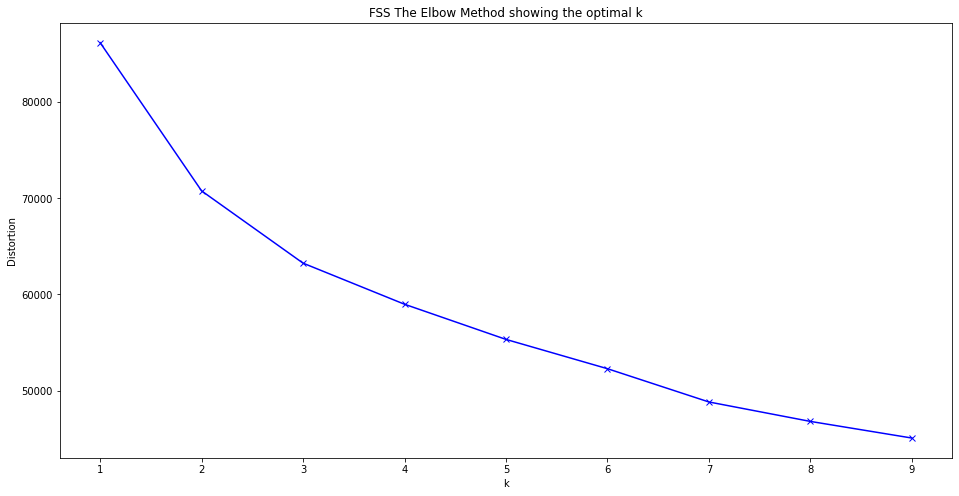

,cluster,num jobs,developer_chosen,num_skills,num_mcqs,num_must_have_skills,num_nice_have_skills,job_value,n_devs_must_have_mcq,n_devs_must_have_self
0,0,374,0.275401,2.307487,2.764706,1.005348,1.310160,11.063739,5469.713904,15167.548128
1,1,707,0.247525,9.137199,8.272984,4.330976,4.831683,11.066230,93.512023,1068.656294
2,2,695,0.246043,4.064748,3.982734,3.074820,0.992806,20.887191,219.594245,1706.976978
3,3,1752,0.204909,2.810502,2.992009,2.719178,0.095320,8.429830,287.985160,1918.563356
4,4,1525,0.194754,4.850492,4.716066,2.795410,2.072131,7.983113,247.851803,2065.180328
5,5,732,0.540984,3.065574,3.196721,2.531421,0.536885,8.648204,362.054645,2102.479508
6,6,1,0.000000,4.000000,2.000000,2.000000,2.000000,11.500000,1375.000000,6140.000000


In [7]:
X = data_fss[[val for val in data_fss.columns if val not in ['id', 'dc_date_bin']]].copy()
X_copy = X.copy()
Y = data_fss['dc_date_bin'].copy()
ID = data_fss['id'].copy()

obj_cols = [col for col in X.columns if X[col].dtype=='object']
X[obj_cols] = X[obj_cols].astype('category')
for col in obj_cols:
    X[col] = X[col].cat.codes

print(X.shape, Y.shape)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)


knn_imp = KNNImputer(n_neighbors=5, add_indicator=False)
knn_imp.fit(rescaledX)
X_final = pd.DataFrame(knn_imp.transform(rescaledX))

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,init='k-means++', verbose=0, random_state=300, n_init=13)
    kmeanModel.fit(X_final)
    distortions.append(kmeanModel.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('FSS The Elbow Method showing the optimal k')
plt.show()

kmeanModel = KMeans(n_clusters=7, init='k-means++', verbose=0, random_state=100, n_init=30)
kmeanModel = kmeanModel.fit(X_final)
X_copy['cluster'] = kmeanModel.labels_
X_copy['target'] = Y
X_copy['job_id'] = ID

X_copy['developer_chosen'] = Y
X_copy.to_csv('clustered-data/fss-cluster-data-2022-08-16.csv')
X_copy.groupby('cluster').agg({'client_type':'count', 'developer_chosen':'mean','num_skills':'mean', 'num_mcqs':'mean', 'num_must_have_skills':'mean', 'num_nice_have_skills':'mean',
                              'job_value':'mean', 'n_devs_must_have_mcq':'mean', 'n_devs_must_have_self':'mean'}).reset_index().rename(columns={'client_type':'num jobs'})

## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.5, min_samples=15, metric='jaccard').fit(X_final)

X_copy['cluster'] = clustering.labels_
X_copy['target'] = Y

X_copy['developer_chosen'] = Y
X_copy.groupby('cluster').agg({'client_type':'count', 'developer_chosen':'mean','num_skills':'mean', 'num_mcqs':'mean', 'num_must_have_skills':'mean', 'num_nice_have_skills':'mean',
                              'job_value':'mean', 'n_devs_must_have_mcq':'mean', 'n_devs_must_have_self':'mean'}).reset_index().rename(columns={'client_type':'num jobs'})


## Enterprise model building

(1490, 16) (1490,)


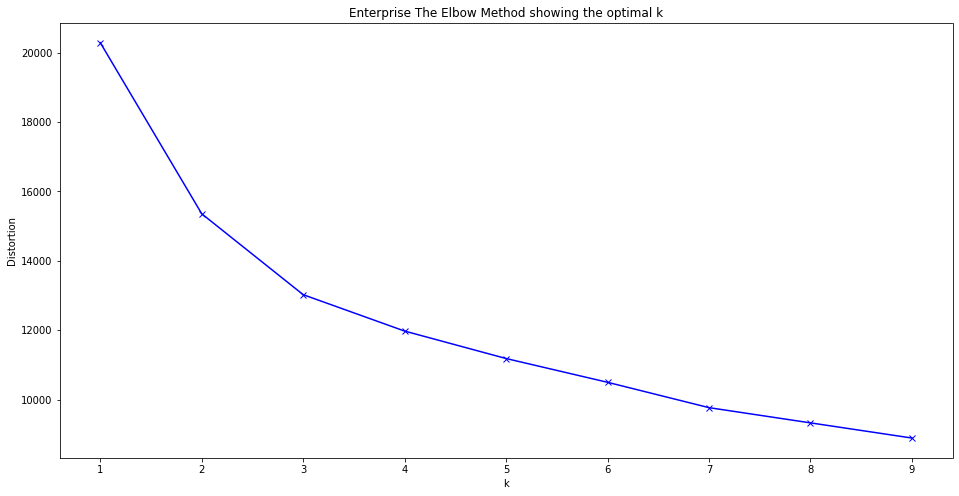

In [8]:
X = data_ets[[val for val in data_ets.columns if val not in ['id', 'dc_date_bin']]].copy()
X_copy = X.copy()
Y = data_ets['dc_date_bin'].copy()
ID = data_ets['id'].copy()

obj_cols = [col for col in X.columns if X[col].dtype=='object']
X[obj_cols] = X[obj_cols].astype('category')
for col in obj_cols:
    X[col] = X[col].cat.codes

print(X.shape, Y.shape)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)


knn_imp = KNNImputer(n_neighbors=5, add_indicator=False)
knn_imp.fit(rescaledX)
X_final = pd.DataFrame(knn_imp.transform(rescaledX))

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,init='k-means++', verbose=0, random_state=100, n_init=30)
    kmeanModel.fit(X_final)
    distortions.append(kmeanModel.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Enterprise The Elbow Method showing the optimal k')
plt.show()


kmeanModel = KMeans(n_clusters=3, init='k-means++', verbose=0, random_state=300, n_init=13)
kmeanModel = kmeanModel.fit(X_final)
X_copy['cluster'] = kmeanModel.labels_
X_copy['developer_chosen'] = Y
X_copy['job_id'] = ID

X_copy.groupby('cluster').agg({'client_type':'count', 'developer_chosen':'mean','num_skills':'mean', 'num_mcqs':'mean', 'num_must_have_skills':'mean', 'num_nice_have_skills':'mean',
                              'job_value':'mean', 'n_devs_must_have_mcq':'mean', 'n_devs_must_have_self':'mean'}).reset_index().rename(columns={'client_type':'num jobs'})

X_copy.to_csv('clustered-data/enterprise-cluster-data-2022-08-16.csv')

In [9]:
X_copy.groupby('cluster').agg({'client_type':'count', 'developer_chosen':'mean','num_skills':'mean', 'num_mcqs':'mean', 'num_must_have_skills':'mean', 'num_nice_have_skills':'mean',
                              'job_value':'mean', 'n_devs_must_have_mcq':'mean', 'n_devs_must_have_self':'mean'}).reset_index().rename(columns={'client_type':'num jobs'})

,cluster,num jobs,developer_chosen,num_skills,num_mcqs,num_must_have_skills,num_nice_have_skills,job_value,n_devs_must_have_mcq,n_devs_must_have_self
0,0,788,0.505076,2.329949,2.285533,2.093909,0.243655,23.813596,406.625635,2274.626904
1,1,191,0.701571,1.340314,2.240838,1.005236,0.356021,24.331414,7824.931937,16907.905759
2,2,511,0.285714,6.203523,5.675147,3.373777,2.837573,31.461144,239.080235,1901.958904


In [ ]:
## demand seg, lower MCQ 
## who were choseen how many elite , and MCQ passed number / skill passed

#-- Developer chosen id will be from table opportunity value and we can join that with pdsa cluster and 


# Can we attach to job search id


# how many packets sent and how many interviews requested/happend and pass/fail rate of 


# in cluster skill distribution for top10



(7239, 15) (7239,)


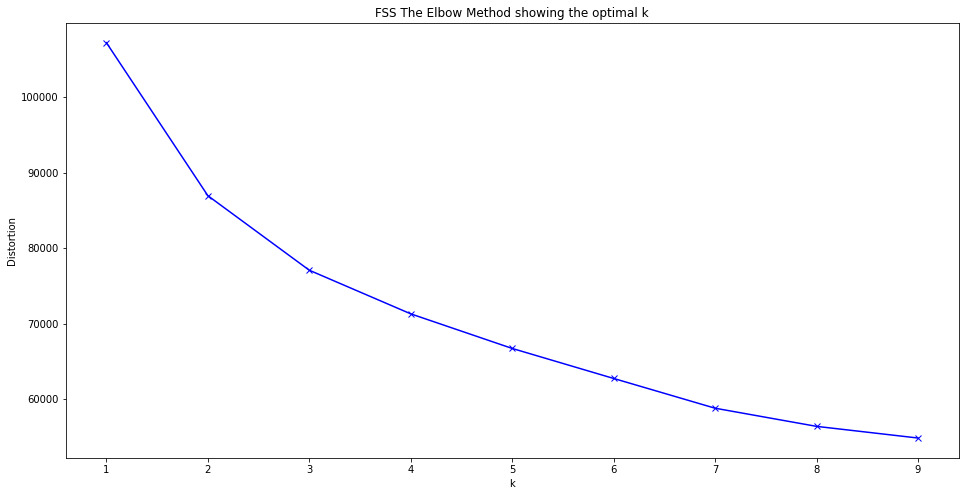

,cluster,num jobs,developer_chosen,num_skills,num_mcqs,num_must_have_skills,num_nice_have_skills,job_value,n_devs_must_have_mcq,n_devs_must_have_self
0,0,538,0.418216,1.884758,2.570632,1.009294,0.888476,16.317308,6298.775093,15946.903346
1,1,1308,0.459480,2.626911,2.606269,2.201070,0.433486,24.001190,387.721713,2253.102446
2,2,2271,0.256715,2.927345,3.075738,2.843681,0.085425,9.354379,275.083223,1855.228974
3,3,1141,0.246275,8.440841,7.747590,4.166521,4.294479,16.182722,129.446976,1279.531113
4,4,1981,0.235235,4.603231,4.455326,2.667845,1.949520,9.741441,309.974760,2173.348814


In [9]:
X = data[[val for val in data.columns if val not in ['id', 'dc_date_bin']]].copy()
X_copy = X.copy()
Y = data['dc_date_bin'].copy()
ID = data['id'].copy()

obj_cols = [col for col in X.columns if X[col].dtype=='object']
X[obj_cols] = X[obj_cols].astype('category')
for col in obj_cols:
    X[col] = X[col].cat.codes

print(X.shape, Y.shape)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)


knn_imp = KNNImputer(n_neighbors=5, add_indicator=False)
knn_imp.fit(rescaledX)
X_final = pd.DataFrame(knn_imp.transform(rescaledX))

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,init='k-means++', verbose=0, random_state=300, n_init=13)
    kmeanModel.fit(X_final)
    distortions.append(kmeanModel.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('FSS The Elbow Method showing the optimal k')
plt.show()

kmeanModel = KMeans(n_clusters=5, init='k-means++', verbose=0, random_state=300, n_init=13)
kmeanModel = kmeanModel.fit(X_final)
X_copy['cluster'] = kmeanModel.labels_
X_copy['target'] = Y

X_copy['developer_chosen'] = Y
X_copy.groupby('cluster').agg({'client_type':'count', 'developer_chosen':'mean','num_skills':'mean', 'num_mcqs':'mean', 'num_must_have_skills':'mean', 'num_nice_have_skills':'mean',
                              'job_value':'mean', 'n_devs_must_have_mcq':'mean', 'n_devs_must_have_self':'mean'}).reset_index().rename(columns={'client_type':'num jobs'})

In [ ]:
X_copy.groupby('cluster').agg(pd.Series.mode)

In [14]:
fss_cd.head(2)

,client_type,client_category,region,role_type,priority,num_skills,num_mcqs,num_must_have_skills,num_nice_have_skills,n_devs_must_have_mcq,n_devs_nice_have_mcq,n_devs_must_have_self,n_devs_nice_have_self,job_value,customer_weekly_hour_engagement,is_deleted,cluster,target,job_id,developer_chosen
4,existing,4.Bronze,2.Rest of US,NaN,NaN,2,3,2,0,114.0,No Nice have skill,7232.0,No Nice have skill,3.9,NaN,0,5,1.0,55,1.0
23,new,4.Bronze,2.Rest of US,NaN,NaN,2,3,2,0,1410.0,No Nice have skill,10025.0,No Nice have skill,7.4,NaN,0,3,1.0,3,1.0


## Cluster to GBQ

In [28]:
ets_cd = pd.read_csv('clustered-data/enterprise-cluster-data-2022-08-16.csv', index_col=0)
fss_cd = pd.read_csv('clustered-data/fss-cluster-data-2022-08-16.csv', index_col=0)

print(ets_cd.groupby('cluster').agg({'job_id':'count', 'developer_chosen':'mean',  'num_must_have_skills':'mean'}))

ets_data = ets_cd[['job_id', 'client_category', 'cluster', 'developer_chosen']].copy()
ets_data['cluster_old'] = ets_cd['cluster']
ets_data['cluster'] = ets_data['cluster'].map({1:0, 0:1, 2:2})
#ets_data.groupby('cluster').agg({'job_id':'count', 'developer_chosen':'mean'})

fss_data = fss_cd[['job_id', 'client_category', 'cluster', 'developer_chosen']].copy()
fss_data['cluster_old'] = fss_cd['cluster']
fss_data = fss_data.loc[fss_data['cluster'].isin([0,1,2,3,4,5])]
fss_data['cluster'] = np.where(fss_data['cluster']==3, 4, fss_data['cluster'])
fss_data['cluster'] = np.where(fss_data['cluster'].isin([0,2]), 1, fss_data['cluster'])
fss_data['cluster'] = fss_data['cluster'].map({5:0, 1:1, 4:2})
#fss_data.groupby('cluster').agg({'job_id':'count', 'developer_chosen':'mean'})

df = pd.concat([ets_data,fss_data])
import pandas_gbq
#pandas_gbq.to_gbq(df, 'pdsa.demand_cluster', project_id='turing-dev-337819', if_exists='append')
